<a href="https://colab.research.google.com/github/shira-chesler/Thesis_tries/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
"""resnet in pytorch



[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.

    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385v1
"""

import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

    def get_residual_function(self):
        return self.residual_function

    def get_shortcut(self):
        return self.shortcut

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the CIFAR100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define a DataLoader for the training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the ResNet model
model = resnet34()

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

100%|██████████| 170498071/170498071 [00:13<00:00, 12983613.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import os
import re
from google.colab import drive

# Mount Google Drive to Colab Notebook
drive.mount('/content/gdrive')

# Define the directory to save the checkpoints
save_dir = '/content/gdrive/My Drive/checkpoints/'

os.makedirs(save_dir, exist_ok=True)

# Check if there are any checkpoint files in the Google Drive directory
checkpoint_files = [f for f in os.listdir(save_dir) if f.endswith('.pth')]
training_finished = False
if checkpoint_files:
    if "model_weights.pth" in checkpoint_files:
        latest_checkpoint_file = "model_weights.pth"
        training_finished = True
    else:
        # Find the checkpoint file with the highest epoch number
        latest_checkpoint_file = max(checkpoint_files, key=lambda x: int(re.search(r'(\d+)', x).group()))
    # Load the state_dict from this checkpoint into the model
    model.load_state_dict(torch.load(os.path.join(save_dir, latest_checkpoint_file)))
    # Start the training loop from the epoch number after the one in the checkpoint
    if training_finished:
      start_epoch = 250
    else:
      start_epoch = int(re.search(r'(\d+)', latest_checkpoint_file).group()) + 1
else:
    start_epoch = 0

Mounted at /content/gdrive


In [ ]:
print(start_epoch)
# Train the model
for epoch in range(start_epoch, 250):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    x = model.state_dict()
    torch.save(x, os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pth'))


print('Finished Training')

250
Finished Training


In [ ]:
# Assuming 'model' is your trained model
if not training_finished:
  torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
'''!pip install torchviz
from torchviz import make_dot

# Forward pass through the model to get the output
inputs, _ = next(iter(train_loader))  # get a batch of data
outputs = model(inputs)  # forward pass

# Visualize the graph
dot = make_dot(outputs.mean(), params=dict(model.named_parameters()))
dot.render("ResNet34_torchviz", format="png")'''

'!pip install torchviz\nfrom torchviz import make_dot\n\n# Forward pass through the model to get the output\ninputs, _ = next(iter(train_loader))  # get a batch of data\noutputs = model(inputs)  # forward pass\n\n# Visualize the graph\ndot = make_dot(outputs.mean(), params=dict(model.named_parameters()))\ndot.render("ResNet34_torchviz", format="png")'

In [ ]:
for module in model.modules():
  print(module)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
'''
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)'''

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|            conv1.0.weight            |    1728    |
|            conv1.1.weight            |     64     |
|             conv1.1.bias             |     64     |
| conv2_x.0.residual_function.0.weight |   36864    |
| conv2_x.0.residual_function.1.weight |     64     |
|  conv2_x.0.residual_function.1.bias  |     64     |
| conv2_x.0.residual_function.3.weight |   36864    |
| conv2_x.0.residual_function.4.weight |     64     |
|  conv2_x.0.residual_function.4.bias  |     64     |
| conv2_x.1.residual_function.0.weight |   36864    |
| conv2_x.1.residual_function.1.weight |     64     |
|  conv2_x.1.residual_function.1.bias  |     64     |
| conv2_x.1.residual_function.3.weight |   36864    |
| conv2_x.1.residual_function.4.weight |     64     |
|  conv2_x.1.residual_function.4.bias  |     64     |
| conv2_x.2.residual_functio

21328292

In [ ]:
'''for layer in model.children():
        print(3, layer)'''

3 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
3 Sequential(
  (0): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 

In [ ]:
import numpy as np
import networkx as nx

def create_neural_network_graph(model):
  G = nx.DiGraph()
  node_pos = {}
  #layer_spacing = 2.5
  #neuron_spacing = 1.0

  # Iterate through the layers of the model
  for i, layer in enumerate(model.children()):
      print(i, layer)
      if isinstance(layer, torch.nn.Linear):
          # Add neurons from the current layer as vertices
          for neuron_out in range(layer.out_features):
              neuron_name_out = f"Layer_{i}_Neuron_{neuron_out}"
              G.add_node(neuron_name_out)

              #node_pos[neuron_name_out] = (i * layer_spacing, -neuron_out * neuron_spacing)

              # Add edges from the previous layer to the current neuron
              if i > 0:
                  for neuron_in in range(layer.in_features):
                      neuron_name_in = f"Layer_{i-1}_Neuron_{neuron_in}"
                      weight = layer.weight[neuron_out][neuron_in].item()
                      G.add_edge(neuron_name_in, neuron_name_out, weight=weight)

      if isinstance(layer, torch.nn.Sequential):
        pass

  return G, node_pos

In [ ]:
create_neural_network_graph(model)

0 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
1 Sequential(
  (0): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 

(<networkx.classes.digraph.DiGraph at 0x7ee5e6c82bf0>, {})

In [ ]:
def add_vx_simple_layer(layer, layer_num, graph):
  has_params = any(p.requires_grad for p in layer.parameters())
  if not has_params:
    return graph
  for neuron_out in range(layer.out_features):
    neuron_name = f"Layer_{layer_num+1}.{neuron_out}"
    graph.add_node(neuron_name)
  return graph


def add_vx_complex_layer(block_layer, rors_type, orig_layer_num, block_num_in_orig_layer, layer_num_in_block, graph):
  if isinstance(block_layer, nn.Conv2d):
    rng = block_layer.out_channels
  elif isinstance(block_layer, nn.BatchNorm2d):
    rng = block_layer.num_features
  else:
    return graph
  for neuron in range(0, rng):
    neuron_name = f"layer_{orig_layer_num+1}.{block_num_in_orig_layer}.{rors_type}.{layer_num_in_block}.{neuron+1}"
    graph.add_node(neuron_name)
  return graph

In [ ]:
def create_vertexes(graph, model):
  G = graph

  for i, layer in enumerate(model.children()):
    # first layer in model - add input ves
    if i == 0:
      for in_channel in range(layer[0].in_channels):
        neuron_name = f"In_channel_{in_channel}"
        G.add_node(neuron_name)
      for j in range(layer[0].out_channels):
        neuron_name = f"layer_{i+1}.0.{j}"
        G.add_node(neuron_name)
      for j in range(layer[1].num_features):
        neuron_name = f"layer_{i+1}.1.{j}"
        G.add_node(neuron_name)

    elif isinstance(layer, torch.nn.Sequential):
      for j, block in enumerate(layer):
        res = block.residual_function
        shrt = block.shortcut
        for k, sub_layer in enumerate(res):
          G = add_vx_complex_layer(sub_layer, "r", i, j, k, G)
        for k, sub_layer in enumerate(shrt):
          G = add_vx_complex_layer(sub_layer, "s", i, j, k, G)

    else:
      G = add_vx_simple_layer(layer, i, G)
  return G

In [ ]:
# in res: batch norm always connects to the one before
#         conv2d - if 0 in block -> connects to the block before. if block is 0 -> connects to layer before
#         conv2d - if not 0 in block - connects to layer -2 in block (prev batch norm)

# in sht:


def add_edges_res(block_layer, kind, orig_layer_num, block_num_in_orig_layer, layer_num_in_block, graph):
  if kind == f"layer_1.1.x": #connects to before first block <- this is conv2d
    pass
  elif kind == f"layer_{orig_layer_num+1}.0.x.0.y": # the zero sub layer in the zero block <- this is conv2d
    pass
  elif kind == f"layer_{orig_layer_num+1}.{block_num_in_orig_layer}.x.0.y": # the zero sub layer in non-zero block <- this is conv2d
    pass
  else:
    pass

def add_edges_sht(block_layer, kind, orig_layer_num, block_num_in_orig_layer, layer_num_in_block, graph):
  pass

In [ ]:
def create_edges(graph, model):
  G = graph
  kindr, kinds = "", ""
  for i, layer in enumerate(model.children()):
    # first layer in model - add input ves
    if i == 0:
      for in_channel in range(layer[0].in_channels): #connect in layer with conv
        for j in range(layer[0].out_channels):
          neuron_name_in = f"In_channel_{in_channel}"
          neuron_name_out = f"layer_{i+1}.0.{j}"
          two_d_tensor = layer[0].weight[j][in_channel]
          weight = two_d_tensor.sum(0).sum().tolist()
          G.add_edge(neuron_name_in, neuron_name_out, weight=weight)

      for j in range(layer[1].num_features):
        neuron_name_in = f"layer_{i+1}.0.{j}"
        neuron_name_out = f"layer_{i+1}.1.{j}"
        weight = layer[1].weight[j].item()
        bias = layer[1].bias[j].item()
        normalized_bias = bias / layer[1].bias.sum().tolist()
        weight += normalized_bias
        G.add_edge(neuron_name_in, neuron_name_out, weight=weight)

      kindr, kinds = "layer_1.1.x", "layer_1.1.x"



    elif isinstance(layer, torch.nn.Sequential):
      for j, block in enumerate(layer):
        res = block.residual_function
        shrt = block.shortcut
        for k, sub_layer in enumerate(res):
          G = add_edges_res(sub_layer, kindr, i, j, k, G)
          kindr = f"layer_{i+1}.{j}.x.{k}.y"
        for k, sub_layer in enumerate(shrt): #empty shortcuts needs edges as well
          G = add_edges_sht(sub_layer, kinds, i, j, k, G)
          kinds = f"layer_{i+1}.{j}.x.{k}.y"

    else:
      G = add_vx_simple_layer(layer, i, G)
  return G


In [ ]:
import numpy as np
import networkx as nx

graph = nx.DiGraph()
g = create_vertexes(graph, model)
g = create_edges(graph, model)

In [ ]:
print(g)

DiGraph with 17127 nodes and 256 edges


TypeError: 'NoneType' object is not iterable

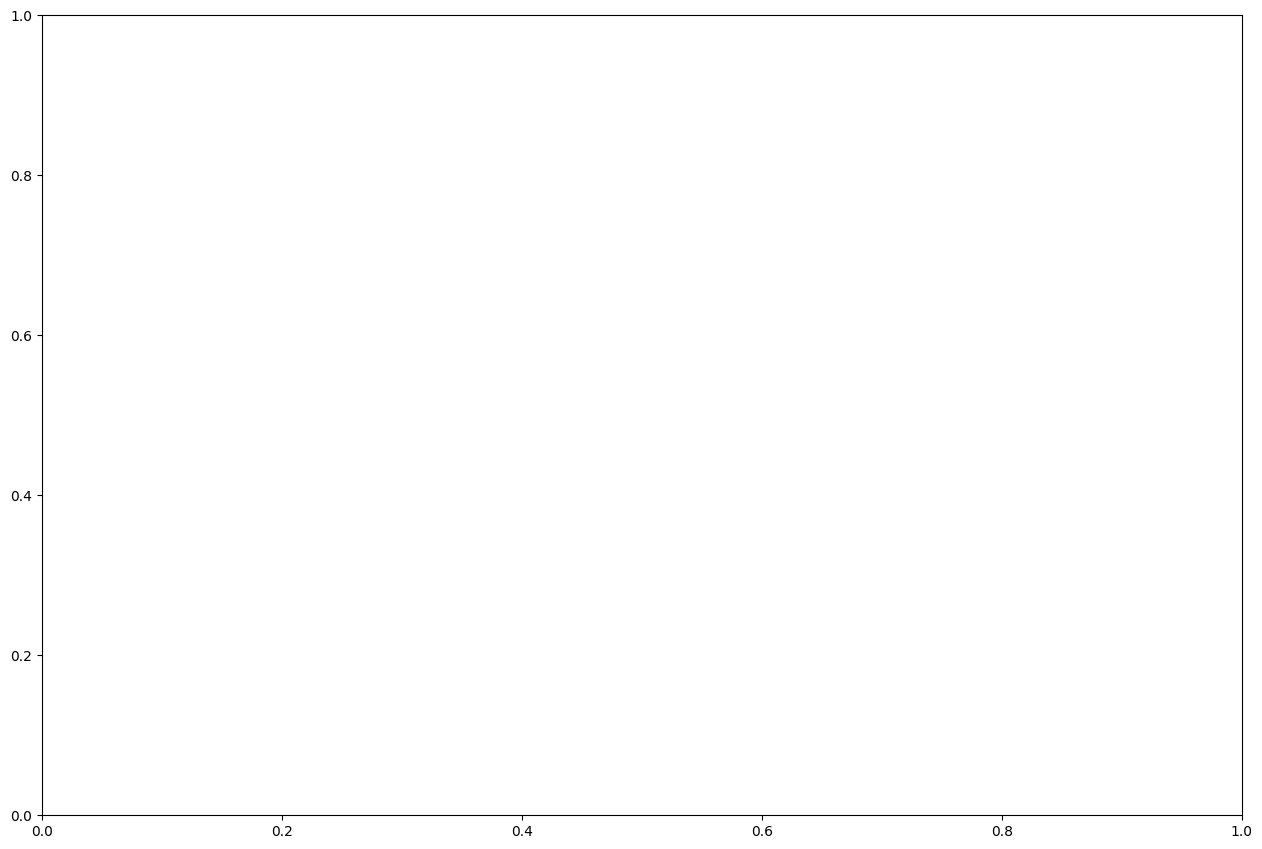

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
nx.draw(g, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray", width=2, arrowstyle="->")
plt.show()

Number of vertices: 5
Number of edges: 6


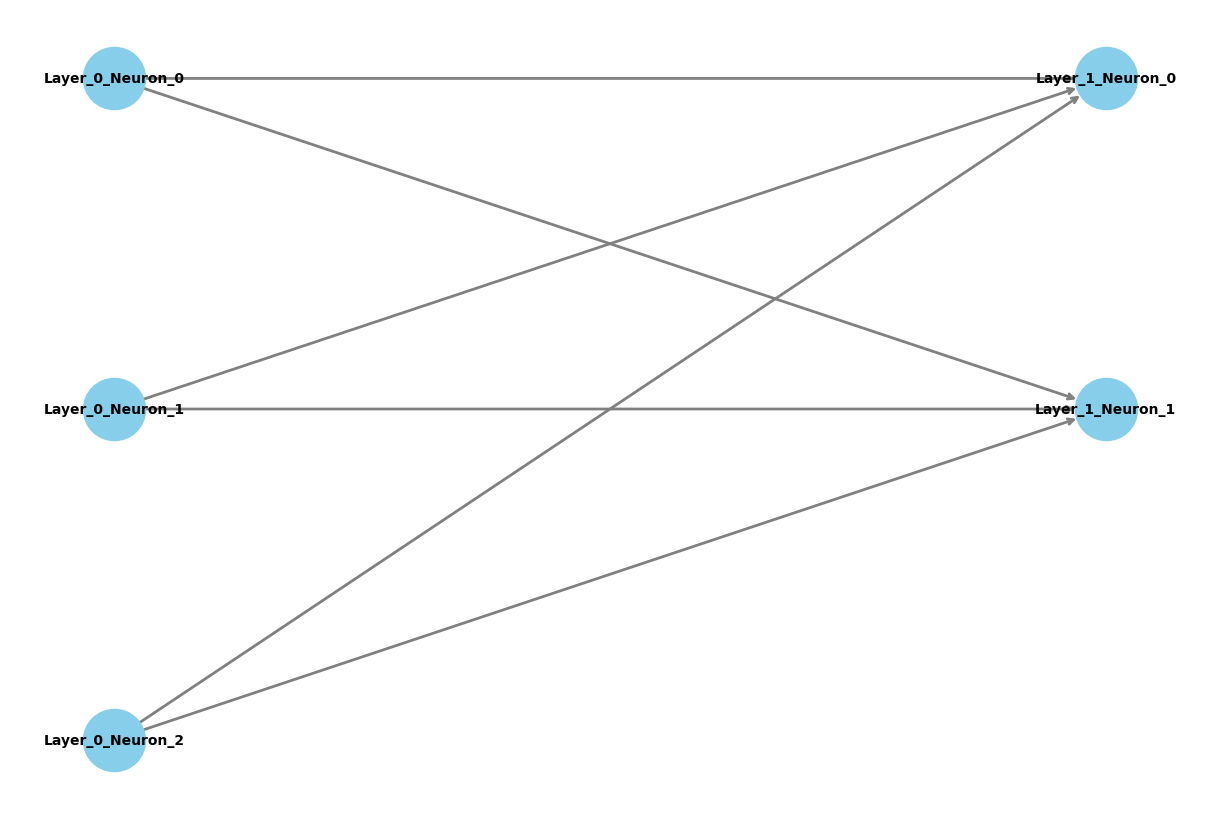